In [73]:
#data preprocessing
import pandas as pd
#produces a prediction model in the form of an ensemble of weak prediction models, typically decision tree
import xgboost as xgb
#the outcome (dependent variable) has only a limited number of possible values. 
#Logistic Regression is used when response variable is categorical in nature.
from sklearn.linear_model import LogisticRegression
#A random forest is a meta estimator that fits a number of decision tree classifiers 
#on various sub-samples of the dataset and use averaging to improve the predictive 
#accuracy and control over-fitting.
from sklearn.ensemble import RandomForestClassifier
#a discriminative classifier formally defined by a separating hyperplane.
from sklearn.svm import SVC
#displayd data
from IPython.display import display
%matplotlib inline

In [74]:
# Read data and drop redundant column.
data = pd.read_csv('Data/final_processed_3.csv')
display(data.head())


# Total number of matches.
n_matches = data.shape[0]

# Calculate number of features. -1 because we are saving one as the target variable (win/lose/draw)
n_features = data.shape[1] - 1

# Calculate matches won by home team.
n_homewins = len(data[data.FTR == 'H'])

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100


# Print the results
print ("Total number of matches: {}".format(n_matches))
print ("Number of features: {}".format(n_features))
print ("Number of matches won by home team: {}".format(n_homewins))
print ("Win rate of home team: {:.2f}%".format(win_rate))

,div,key,team1,team2,date,FTR,team1_home_win,team1_home_draw,team1_away_win,team1_away_draw,...,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,home_player_overall,away_player_overall,home_team_overall,away_team_overall
0,702,Stoke_Hull_2010-04-03,4,7,2010-04-03,H,0.472222,0.277778,0.147059,0.323529,...,18.0,0.00,1.35,1.30,3.60,3.25,66,66,429,431
1,341,Middlesbrough_Man United_2009-05-02,9,19,2009-05-02,A,0.277778,0.444444,0.117647,0.117647,...,18.0,1.00,1.81,1.78,2.15,2.09,65,68,395,420
2,1514,Stoke_Bolton_2012-05-13,4,3,2012-05-13,D,0.447368,0.302632,0.171053,0.250000,...,19.0,-0.25,2.07,2.03,1.89,1.84,68,66,429,467
3,812,Blackpool_Blackburn_2010-09-25,24,6,2010-09-25,A,0.000000,0.500000,0.500000,0.000000,...,22.0,0.00,2.41,2.22,1.68,1.62,64,68,459,501
4,1682,Newcastle_Man City_2012-12-15,20,16,2012-12-15,A,0.393939,0.318182,0.230769,0.276923,...,25.0,0.75,2.05,1.99,1.92,1.87,68,68,430,370


Total number of matches: 3040
Number of features: 95
Number of matches won by home team: 1390
Win rate of home team: 45.72%


In [75]:
# Separate into feature set and target variable
#FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
X_all =data.drop(['div','FTR', 'key', 'date', 'WHH','WHD','WHA'], axis=1)  # df.columns is zero-based pd.Index
# X_all =X_all.drop(0, axis=1)  # df.columns is zero-based pd.Index 

y_all = data['FTR']

display(X_all.head())
print(X_all.shape)

,team1,team2,team1_home_win,team1_home_draw,team1_away_win,team1_away_draw,team1_home_goals,team1_away_goals,team1_home_goals_conceded,team1_away_goals_conceded,...,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,home_player_overall,away_player_overall,home_team_overall,away_team_overall
0,4,7,0.472222,0.277778,0.147059,0.323529,1.250000,0.735294,0.944444,1.647059,...,18.0,0.00,1.35,1.30,3.60,3.25,66,66,429,431
1,9,19,0.277778,0.444444,0.117647,0.117647,0.888889,0.529412,1.055556,1.882353,...,18.0,1.00,1.81,1.78,2.15,2.09,65,68,395,420
2,4,3,0.447368,0.302632,0.171053,0.250000,1.342105,0.684211,0.973684,1.710526,...,19.0,-0.25,2.07,2.03,1.89,1.84,68,66,429,467
3,24,6,0.000000,0.500000,0.500000,0.000000,1.500000,1.500000,2.000000,2.500000,...,22.0,0.00,2.41,2.22,1.68,1.62,64,68,459,501
4,20,16,0.393939,0.318182,0.230769,0.276923,1.590909,1.015385,1.287879,1.661538,...,25.0,0.75,2.05,1.99,1.92,1.87,68,68,430,370


(3040, 89)


In [76]:
def preprocess_features(X):
    ''' Preprocesses the football data and converts catagorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

# Standardising the data.
from sklearn.preprocessing import scale
cols = X_all.columns

for col in cols:
    X_all[col] = scale(X_all[col])
X_all = preprocess_features(X_all)


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [80]:
### Final  Feature selection algorithms
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.model_selection import train_test_split

print(X_all.shape)
X = SelectKBest(score_func=f_classif, k=45).fit_transform(X_all,y_all)

#Final splitting
X_train, X_test, y_train, y_test = train_test_split(X, y_all, 
                                                    test_size = 0.2,
                                                    shuffle = False)

(3040, 89)


In [86]:
#for measuring training time
from time import time 
# F1 score (also F-score or F-measure) is a measure of a test's accuracy. 
#It considers both the precision p and the recall r of the test to compute 
#the score: p is the number of correct positive results divided by the number of 
#all positive results, and r is the number of correct positive results divided by 
#the number of positive results that should have been returned. The F1 score can be 
#interpreted as a weighted average of the precision and recall, where an F1 score 
#reaches its best value at 1 and worst at 0.
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in seconds", (end - start))
    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    
    end = time()
    # Print and return results
    print ("Made predictions in seconds.",(end - start))
    
    return 0,sum(target == y_pred) / float(len(y_pred)),y_pred


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
#     print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc, predicted_labels = predict_labels(clf, X_train, y_train)
#     print (f1, acc)
#     print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc, predicted_labels = predict_labels(clf, X_test, y_test)
    print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))
    return acc,predicted_labels

In [82]:
# Initialize the three models (XGBoost is initialized later)
##Final accuracy calculator..with best feature.

clf_A = LogisticRegression(random_state = 42)
clf_B = SVC(random_state = 912, kernel='rbf')
clf_C = xgb.XGBClassifier(seed = 82)

train_predict(clf_A, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_B, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_C, X_train, y_train, X_test, y_test)
print ('')



Trained model in seconds 0.1185312271118164
Made predictions in seconds. 0.00063323974609375
Made predictions in seconds. 0.0002663135528564453
F1 score and accuracy score for test set: 0.0000 , 0.6299.

Trained model in seconds 0.6030681133270264
Made predictions in seconds. 0.45496368408203125
Made predictions in seconds. 0.12002110481262207
F1 score and accuracy score for test set: 0.0000 , 0.6217.

Trained model in seconds 1.3971879482269287
Made predictions in seconds. 0.03170061111450195
Made predictions in seconds. 0.008270978927612305
F1 score and accuracy score for test set: 0.0000 , 0.6628.



/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Trained model in seconds 0.06281709671020508
Made predictions in seconds. 0.0006768703460693359
Made predictions in seconds. 0.00030159950256347656
F1 score and accuracy score for test set: 0.0000 , 0.6299.
Trained model in seconds 0.42436647415161133
Made predictions in seconds. 0.29881930351257324
Made predictions in seconds. 0.09749579429626465
F1 score and accuracy score for test set: 0.0000 , 0.6217.
Trained model in seconds 1.1061580181121826
Made predictions in seconds. 0.022383451461791992
Made predictions in seconds. 0.006066083908081055
F1 score and accuracy score for test set: 0.0000 , 0.6628.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


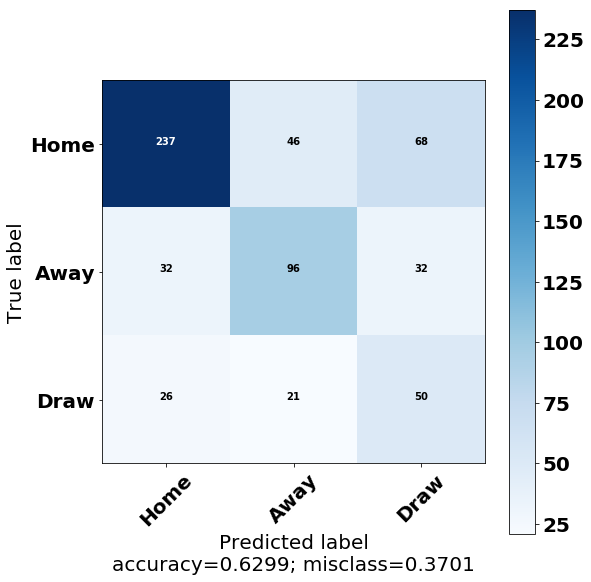

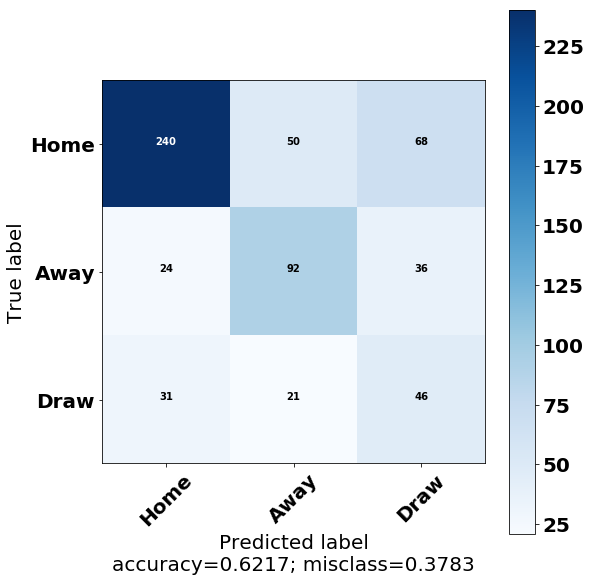

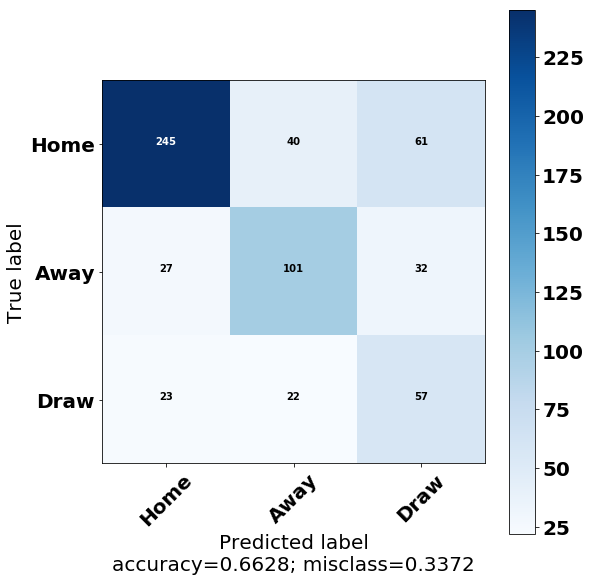

In [109]:
###Model Evaluation for Xg booost
##confusion matrix
import numpy as np

import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True, filename ='cm'):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig = plt.figure(figsize=(8, 8))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=20)
    fig.savefig(filename)

    plt.show()

labels = ['H','A','D']
def ConfusionMatrix(expexted_y, output_y):
    C = np.zeros((3,3), dtype=int)
    for xx, yy in zip(expexted_y, output_y):
        C[labels.index(xx),labels.index(yy)] = C[labels.index(xx),labels.index(yy)] + 1;  
    return C

clf_A = LogisticRegression(random_state = 42)
clf_B = SVC(random_state = 912, kernel='rbf')
clf_C = xgb.XGBClassifier(seed = 82)
acc1,output_y1 =train_predict(clf_A, X_train, y_train, X_test, y_test)
acc2,output_y2 =train_predict(clf_B, X_train, y_train, X_test, y_test)
acc3,output_y3 =train_predict(clf_C, X_train, y_train, X_test, y_test)


C1= ConfusionMatrix(output_y1, y_test)
C2= ConfusionMatrix(output_y2, y_test)
C3= ConfusionMatrix(output_y3, y_test)

plot_confusion_matrix(cm           = np.array(C1),
                      normalize    = False,
                      target_names = ['Home', 'Away', 'Draw'],
                      title        = "Confusion Matrix",
                      filename  = "confusion_matrix_Logistic_reg.png"
                     )
plot_confusion_matrix(cm           = np.array(C2),
                      normalize    = False,
                      target_names = ['Home', 'Away', 'Draw'],
                      title        = "Confusion Matrix",
                      filename  = "confusion_matrix_SVC.png"
                     )
plot_confusion_matrix(cm           = np.array(C3),
                      normalize    = False,
                      target_names = ['Home', 'Away', 'Draw'],
                      title        = "Confusion Matrix",
                      filename  = "confusion_matrix_xg_boost.png"
                     )

# print("Confusion matrixxx", C)
# print("Home wins rightly predicted",(C[0][0]/sum(C[0]))*100)
# print("Away wins rightly predicted",(C[1][1]/sum(C[1]))*100)
# print("Draw wins rightly predicted",(C[2][2]/sum(C[2]))*100)



In [46]:
#### Feature selection to find out the best number of features
### Feature selection algorithms
'''
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif

def selectFeature(feature, num):
    
    
    # Initialize the three models (XGBoost is initialized later)
    clf_A = LogisticRegression(random_state = 42)
    clf_B = SVC(random_state = 912, kernel='rbf')
    clf_C = xgb.XGBClassifier(seed = 34)
    
    X = SelectKBest(score_func=feature, k=num).fit_transform(X_all,y_all)
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_all, 
                                                    test_size = 0.2,
                                                    shuffle = False)
#   
    a1 = train_predict(clf_A, X_train, y_train, X_test, y_test)
#     print ('')
    a2 = train_predict(clf_B, X_train, y_train, X_test, y_test)
#     print ('')
    a3= train_predict(clf_C, X_train, y_train, X_test, y_test)
#     print ('')
    return [a1,a2,a3]


##Running for different features
features = [mutual_info_classif]
all_accuracies = []
x_points =[]
y_modelAccuracies = [[],[],[]]
# for f in features:
#     temp =[]
for num in range(10,X_all.shape[1]):
    x_points.append(num)
    a1,a2,a3 = selectFeature(mutual_info_classif,num)
    y_modelAccuracies[0].append(a1 * 100)
    y_modelAccuracies[1].append(a2 * 100)
    y_modelAccuracies[2].append(a3 * 100)
    
print("points", x_points)  
print("y_models", y_modelAccuracies)  

# print("The Max accuracy is ", max(temp), " for number ", temp.index(max(temp))+10)
# all_accuracies.append((f, temp))
'''


F1 score and accuracy score for test set: 0.0000 , 0.5822.
F1 score and accuracy score for test set: 0.0000 , 0.5674.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.5641.
F1 score and accuracy score for test set: 0.0000 , 0.6086.
F1 score and accuracy score for test set: 0.0000 , 0.6003.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6086.
F1 score and accuracy score for test set: 0.0000 , 0.5954.
F1 score and accuracy score for test set: 0.0000 , 0.5905.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6020.
F1 score and accuracy score for test set: 0.0000 , 0.6135.
F1 score and accuracy score for test set: 0.0000 , 0.6003.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6102.
F1 score and accuracy score for test set: 0.0000 , 0.5954.
F1 score and accuracy score for test set: 0.0000 , 0.5905.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.5954.
F1 score and accuracy score for test set: 0.0000 , 0.6184.
F1 score and accuracy score for test set: 0.0000 , 0.6201.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6201.
F1 score and accuracy score for test set: 0.0000 , 0.6118.
F1 score and accuracy score for test set: 0.0000 , 0.6003.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6036.
F1 score and accuracy score for test set: 0.0000 , 0.6151.
F1 score and accuracy score for test set: 0.0000 , 0.6184.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6184.
F1 score and accuracy score for test set: 0.0000 , 0.6151.
F1 score and accuracy score for test set: 0.0000 , 0.6168.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6151.
F1 score and accuracy score for test set: 0.0000 , 0.6201.
F1 score and accuracy score for test set: 0.0000 , 0.6151.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6151.
F1 score and accuracy score for test set: 0.0000 , 0.6184.
F1 score and accuracy score for test set: 0.0000 , 0.6168.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6168.
F1 score and accuracy score for test set: 0.0000 , 0.6184.
F1 score and accuracy score for test set: 0.0000 , 0.6234.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6299.
F1 score and accuracy score for test set: 0.0000 , 0.6201.
F1 score and accuracy score for test set: 0.0000 , 0.6151.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6234.
F1 score and accuracy score for test set: 0.0000 , 0.6217.
F1 score and accuracy score for test set: 0.0000 , 0.6135.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6234.
F1 score and accuracy score for test set: 0.0000 , 0.6299.
F1 score and accuracy score for test set: 0.0000 , 0.6102.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6234.
F1 score and accuracy score for test set: 0.0000 , 0.6266.
F1 score and accuracy score for test set: 0.0000 , 0.6135.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6250.
F1 score and accuracy score for test set: 0.0000 , 0.6299.
F1 score and accuracy score for test set: 0.0000 , 0.6118.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6382.
F1 score and accuracy score for test set: 0.0000 , 0.6332.
F1 score and accuracy score for test set: 0.0000 , 0.6118.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6250.
F1 score and accuracy score for test set: 0.0000 , 0.6299.
F1 score and accuracy score for test set: 0.0000 , 0.6151.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6316.
F1 score and accuracy score for test set: 0.0000 , 0.6365.
F1 score and accuracy score for test set: 0.0000 , 0.6135.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6332.
F1 score and accuracy score for test set: 0.0000 , 0.6151.
F1 score and accuracy score for test set: 0.0000 , 0.6135.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6316.
F1 score and accuracy score for test set: 0.0000 , 0.6151.
F1 score and accuracy score for test set: 0.0000 , 0.6184.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6299.
F1 score and accuracy score for test set: 0.0000 , 0.6283.
F1 score and accuracy score for test set: 0.0000 , 0.6217.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6414.
F1 score and accuracy score for test set: 0.0000 , 0.6299.
F1 score and accuracy score for test set: 0.0000 , 0.6184.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6414.
F1 score and accuracy score for test set: 0.0000 , 0.6234.
F1 score and accuracy score for test set: 0.0000 , 0.6168.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6365.
F1 score and accuracy score for test set: 0.0000 , 0.6168.
F1 score and accuracy score for test set: 0.0000 , 0.6217.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6299.
F1 score and accuracy score for test set: 0.0000 , 0.6201.
F1 score and accuracy score for test set: 0.0000 , 0.6151.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6382.
F1 score and accuracy score for test set: 0.0000 , 0.6250.
F1 score and accuracy score for test set: 0.0000 , 0.6151.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6283.
F1 score and accuracy score for test set: 0.0000 , 0.6118.
F1 score and accuracy score for test set: 0.0000 , 0.6168.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6283.
F1 score and accuracy score for test set: 0.0000 , 0.6168.
F1 score and accuracy score for test set: 0.0000 , 0.6135.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6316.
F1 score and accuracy score for test set: 0.0000 , 0.6201.
F1 score and accuracy score for test set: 0.0000 , 0.6201.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6332.
F1 score and accuracy score for test set: 0.0000 , 0.6234.
F1 score and accuracy score for test set: 0.0000 , 0.6217.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6431.
F1 score and accuracy score for test set: 0.0000 , 0.6316.
F1 score and accuracy score for test set: 0.0000 , 0.6299.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6431.
F1 score and accuracy score for test set: 0.0000 , 0.6184.
F1 score and accuracy score for test set: 0.0000 , 0.6102.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6349.
F1 score and accuracy score for test set: 0.0000 , 0.6234.
F1 score and accuracy score for test set: 0.0000 , 0.6184.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6283.
F1 score and accuracy score for test set: 0.0000 , 0.6234.
F1 score and accuracy score for test set: 0.0000 , 0.6151.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6283.
F1 score and accuracy score for test set: 0.0000 , 0.6201.
F1 score and accuracy score for test set: 0.0000 , 0.6184.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6316.
F1 score and accuracy score for test set: 0.0000 , 0.6184.
F1 score and accuracy score for test set: 0.0000 , 0.6069.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6398.
F1 score and accuracy score for test set: 0.0000 , 0.6234.
F1 score and accuracy score for test set: 0.0000 , 0.6118.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6349.
F1 score and accuracy score for test set: 0.0000 , 0.6283.
F1 score and accuracy score for test set: 0.0000 , 0.6283.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6431.
F1 score and accuracy score for test set: 0.0000 , 0.6283.
F1 score and accuracy score for test set: 0.0000 , 0.6283.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6398.
F1 score and accuracy score for test set: 0.0000 , 0.6201.
F1 score and accuracy score for test set: 0.0000 , 0.6086.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6234.
F1 score and accuracy score for test set: 0.0000 , 0.6250.
F1 score and accuracy score for test set: 0.0000 , 0.6102.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6332.
F1 score and accuracy score for test set: 0.0000 , 0.6283.
F1 score and accuracy score for test set: 0.0000 , 0.6234.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6497.
F1 score and accuracy score for test set: 0.0000 , 0.6283.
F1 score and accuracy score for test set: 0.0000 , 0.6266.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6365.
F1 score and accuracy score for test set: 0.0000 , 0.6283.
F1 score and accuracy score for test set: 0.0000 , 0.6316.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6513.
F1 score and accuracy score for test set: 0.0000 , 0.6283.
F1 score and accuracy score for test set: 0.0000 , 0.6316.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6414.
F1 score and accuracy score for test set: 0.0000 , 0.6365.
F1 score and accuracy score for test set: 0.0000 , 0.6201.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6431.
F1 score and accuracy score for test set: 0.0000 , 0.6250.
F1 score and accuracy score for test set: 0.0000 , 0.6118.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6349.
F1 score and accuracy score for test set: 0.0000 , 0.6349.
F1 score and accuracy score for test set: 0.0000 , 0.6135.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6530.
F1 score and accuracy score for test set: 0.0000 , 0.6266.
F1 score and accuracy score for test set: 0.0000 , 0.6184.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1 score and accuracy score for test set: 0.0000 , 0.6316.
F1 score and accuracy score for test set: 0.0000 , 0.6332.
F1 score and accuracy score for test set: 0.0000 , 0.6217.


KeyboardInterrupt: 

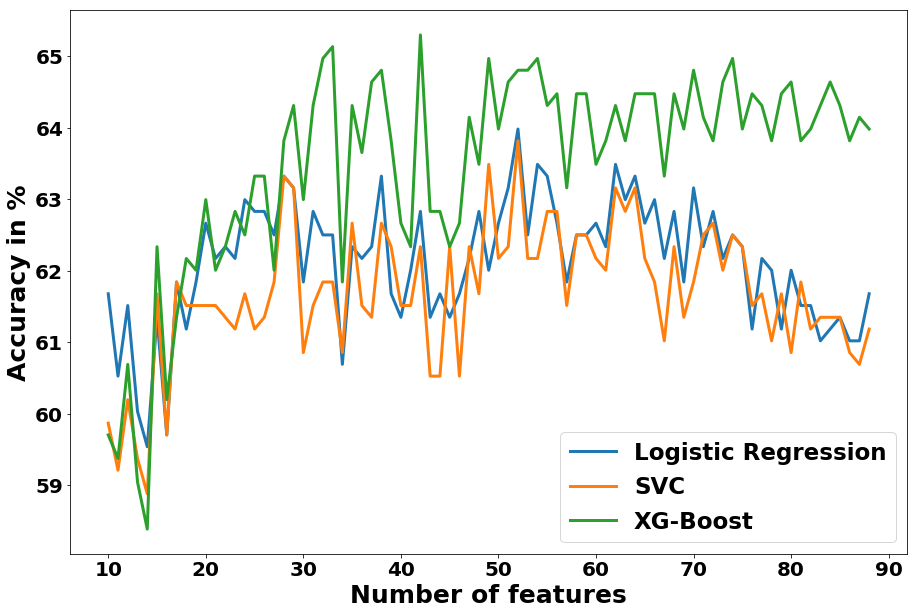

In [52]:
import matplotlib.pylab as plt
%matplotlib inline

# ##f_classif
# x_points =[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88]
# y_modelAccuracies= [[61.51315789473685, 61.67763157894737, 61.348684210526315, 61.8421052631579, 62.00657894736842, 61.67763157894737, 61.67763157894737, 61.348684210526315, 61.51315789473685, 61.348684210526315, 62.00657894736842, 62.5, 61.67763157894737, 62.335526315789465, 62.17105263157895, 62.335526315789465, 63.98026315789473, 63.48684210526315, 63.81578947368421, 63.98026315789473, 63.651315789473685, 63.81578947368421, 62.664473684210535, 62.82894736842105, 62.99342105263158, 62.99342105263158, 63.48684210526315, 63.32236842105263, 63.32236842105263, 63.48684210526315, 62.5, 62.82894736842105, 62.99342105263158, 62.664473684210535, 63.1578947368421, 62.99342105263158, 61.51315789473685, 62.17105263157895, 62.17105263157895, 62.335526315789465, 62.335526315789465, 62.335526315789465, 62.5, 62.5, 63.32236842105263, 63.1578947368421, 62.82894736842105, 62.82894736842105, 62.82894736842105, 63.32236842105263, 63.651315789473685, 63.48684210526315, 62.99342105263158, 62.335526315789465, 62.5, 62.82894736842105, 62.17105263157895, 62.335526315789465, 62.664473684210535, 62.5, 62.5, 62.5, 62.664473684210535, 62.5, 62.82894736842105, 62.82894736842105, 62.17105263157895, 62.5, 62.335526315789465, 61.67763157894737, 61.67763157894737, 61.348684210526315, 61.01973684210527, 61.01973684210527, 61.18421052631579, 61.348684210526315, 60.69078947368421, 61.01973684210527, 61.348684210526315], [60.0328947368421, 59.539473684210535, 59.70394736842105, 59.86842105263158, 60.0328947368421, 61.348684210526315, 61.18421052631579, 61.51315789473685, 61.67763157894737, 61.8421052631579, 60.69078947368421, 61.51315789473685, 62.335526315789465, 62.99342105263158, 62.335526315789465, 62.335526315789465, 62.17105263157895, 62.664473684210535, 62.335526315789465, 62.5, 62.82894736842105, 63.48684210526315, 63.81578947368421, 63.48684210526315, 63.32236842105263, 63.98026315789473, 63.1578947368421, 62.664473684210535, 62.335526315789465, 62.99342105263158, 62.664473684210535, 63.1578947368421, 62.99342105263158, 62.5, 63.1578947368421, 62.17105263157895, 62.82894736842105, 63.32236842105263, 62.99342105263158, 62.99342105263158, 62.82894736842105, 62.82894736842105, 62.5, 62.5, 62.5, 62.17105263157895, 62.664473684210535, 63.1578947368421, 62.99342105263158, 62.82894736842105, 62.664473684210535, 62.82894736842105, 62.17105263157895, 62.82894736842105, 62.5, 62.17105263157895, 62.17105263157895, 62.335526315789465, 62.82894736842105, 62.664473684210535, 62.664473684210535, 62.17105263157895, 62.5, 62.17105263157895, 62.00657894736842, 62.17105263157895, 62.17105263157895, 62.335526315789465, 62.335526315789465, 61.01973684210527, 61.18421052631579, 61.18421052631579, 61.18421052631579, 60.69078947368421, 61.01973684210527, 61.01973684210527, 61.01973684210527, 60.85526315789473, 60.85526315789473], [60.36184210526315, 60.0328947368421, 59.539473684210535, 59.86842105263158, 60.526315789473685, 62.335526315789465, 62.17105263157895, 61.18421052631579, 61.51315789473685, 62.00657894736842, 62.17105263157895, 63.1578947368421, 63.48684210526315, 64.14473684210526, 64.80263157894737, 63.48684210526315, 64.47368421052632, 64.14473684210526, 64.14473684210526, 64.47368421052632, 63.81578947368421, 63.98026315789473, 62.99342105263158, 62.99342105263158, 62.664473684210535, 63.48684210526315, 63.98026315789473, 64.30921052631578, 64.63815789473685, 64.47368421052632, 64.30921052631578, 63.98026315789473, 64.9671052631579, 64.80263157894737, 65.29605263157895, 66.2828947368421, 64.9671052631579, 64.30921052631578, 65.29605263157895, 65.13157894736842, 64.63815789473685, 64.63815789473685, 63.98026315789473, 63.98026315789473, 64.47368421052632, 64.63815789473685, 63.48684210526315, 63.98026315789473, 64.63815789473685, 65.29605263157895, 64.47368421052632, 64.30921052631578, 63.81578947368421, 64.30921052631578, 64.14473684210526, 64.80263157894737, 64.47368421052632, 64.80263157894737, 64.63815789473685, 64.9671052631579, 63.81578947368421, 64.80263157894737, 64.30921052631578, 64.47368421052632, 64.47368421052632, 64.9671052631579, 63.81578947368421, 63.98026315789473, 64.30921052631578, 64.47368421052632, 64.80263157894737, 63.98026315789473, 63.48684210526315, 64.14473684210526, 64.63815789473685, 64.14473684210526, 63.651315789473685, 64.30921052631578, 64.30921052631578]]

##mutualinfo
x_points =[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88];
y_modelAccuracies = [[61.67763157894737, 60.526315789473685, 61.51315789473685, 60.0328947368421, 59.539473684210535, 61.348684210526315, 59.70394736842105, 61.8421052631579, 61.18421052631579, 61.8421052631579, 62.664473684210535, 62.17105263157895, 62.335526315789465, 62.17105263157895, 62.99342105263158, 62.82894736842105, 62.82894736842105, 62.5, 63.32236842105263, 63.1578947368421, 61.8421052631579, 62.82894736842105, 62.5, 62.5, 60.69078947368421, 62.335526315789465, 62.17105263157895, 62.335526315789465, 63.32236842105263, 61.67763157894737, 61.348684210526315, 62.00657894736842, 62.82894736842105, 61.348684210526315, 61.67763157894737, 61.348684210526315, 61.67763157894737, 62.17105263157895, 62.82894736842105, 62.00657894736842, 62.664473684210535, 63.1578947368421, 63.98026315789473, 62.5, 63.48684210526315, 63.32236842105263, 62.664473684210535, 61.8421052631579, 62.5, 62.5, 62.664473684210535, 62.335526315789465, 63.48684210526315, 62.99342105263158, 63.32236842105263, 62.664473684210535, 62.99342105263158, 62.17105263157895, 62.82894736842105, 61.8421052631579, 63.1578947368421, 62.335526315789465, 62.82894736842105, 62.17105263157895, 62.5, 62.335526315789465, 61.18421052631579, 62.17105263157895, 62.00657894736842, 61.18421052631579, 62.00657894736842, 61.51315789473685, 61.51315789473685, 61.01973684210527, 61.18421052631579, 61.348684210526315, 61.01973684210527, 61.01973684210527, 61.67763157894737], [59.86842105263158, 59.210526315789465, 60.19736842105263, 59.375, 58.88157894736842, 61.67763157894737, 59.70394736842105, 61.8421052631579, 61.51315789473685, 61.51315789473685, 61.51315789473685, 61.51315789473685, 61.348684210526315, 61.18421052631579, 61.67763157894737, 61.18421052631579, 61.348684210526315, 61.8421052631579, 63.32236842105263, 63.1578947368421, 60.85526315789473, 61.51315789473685, 61.8421052631579, 61.8421052631579, 60.85526315789473, 62.664473684210535, 61.51315789473685, 61.348684210526315, 62.664473684210535, 62.335526315789465, 61.51315789473685, 61.51315789473685, 62.335526315789465, 60.526315789473685, 60.526315789473685, 62.335526315789465, 60.526315789473685, 62.335526315789465, 61.67763157894737, 63.48684210526315, 62.17105263157895, 62.335526315789465, 63.81578947368421, 62.17105263157895, 62.17105263157895, 62.82894736842105, 62.82894736842105, 61.51315789473685, 62.5, 62.5, 62.17105263157895, 62.00657894736842, 63.1578947368421, 62.82894736842105, 63.1578947368421, 62.17105263157895, 61.8421052631579, 61.01973684210527, 62.335526315789465, 61.348684210526315, 61.8421052631579, 62.5, 62.664473684210535, 62.00657894736842, 62.5, 62.335526315789465, 61.51315789473685, 61.67763157894737, 61.01973684210527, 61.67763157894737, 60.85526315789473, 61.8421052631579, 61.18421052631579, 61.348684210526315, 61.348684210526315, 61.348684210526315, 60.85526315789473, 60.69078947368421, 61.18421052631579], [59.70394736842105, 59.375, 60.69078947368421, 59.04605263157895, 58.38815789473685, 62.335526315789465, 60.19736842105263, 61.348684210526315, 62.17105263157895, 62.00657894736842, 62.99342105263158, 62.00657894736842, 62.335526315789465, 62.82894736842105, 62.5, 63.32236842105263, 63.32236842105263, 62.00657894736842, 63.81578947368421, 64.30921052631578, 62.99342105263158, 64.30921052631578, 64.9671052631579, 65.13157894736842, 61.8421052631579, 64.30921052631578, 63.651315789473685, 64.63815789473685, 64.80263157894737, 63.81578947368421, 62.664473684210535, 62.335526315789465, 65.29605263157895, 62.82894736842105, 62.82894736842105, 62.335526315789465, 62.664473684210535, 64.14473684210526, 63.48684210526315, 64.9671052631579, 63.98026315789473, 64.63815789473685, 64.80263157894737, 64.80263157894737, 64.9671052631579, 64.30921052631578, 64.47368421052632, 63.1578947368421, 64.47368421052632, 64.47368421052632, 63.48684210526315, 63.81578947368421, 64.30921052631578, 63.81578947368421, 64.47368421052632, 64.47368421052632, 64.47368421052632, 63.32236842105263, 64.47368421052632, 63.98026315789473, 64.80263157894737, 64.14473684210526, 63.81578947368421, 64.63815789473685, 64.9671052631579, 63.98026315789473, 64.47368421052632, 64.30921052631578, 63.81578947368421, 64.47368421052632, 64.63815789473685, 63.81578947368421, 63.98026315789473, 64.30921052631578, 64.63815789473685, 64.30921052631578, 63.81578947368421, 64.14473684210526, 63.98026315789473]]

# plt.rcParams["font.weight"] = "bold"
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

fig=plt.figure(figsize=(15,10))
plt.plot(x_points,  y_modelAccuracies[0],   label="Logistic Regression",linewidth=3.0)
plt.plot(x_points,  y_modelAccuracies[1],   label="SVC", linewidth=3.0)
plt.plot(x_points,  y_modelAccuracies[2],   label="XG-Boost", linewidth=3.0)

# plt.title("Accuracy vs Features using f_Classif", fontsize=20, fontweight="bold")
plt.xlabel("Number of features", fontsize=25, fontweight="bold")
plt.ylabel("Accuracy in %", fontsize=25, fontweight="bold")

plt.legend(loc=4, fontsize = '23')

fig.savefig('mutual_info.png')

plt.show()



In [148]:
# ###Trying to optimize the hyperparameter
# # TODO: Import 'GridSearchCV' and 'make_scorer'
# from sklearn.grid_search import GridSearchCV
# from sklearn.metrics import make_scorer


# # TODO: Create the parameters list you wish to tune
# parameters = { 'learning_rate' : [0.1],
#                'n_estimators' : [40],
#                'max_depth': [3],
#                'min_child_weight': [3],
#                'gamma':[0.4],
#                'subsample' : [0.8],
#                'colsample_bytree' : [0.8],
#                'scale_pos_weight' : [1],
#                'reg_alpha':[1e-5]
#              }  

# # TODO: Initialize the classifier
# clf = xgb.XGBClassifier(seed=2)

# # TODO: Make an f1 scoring function using 'make_scorer' 
# f1_scorer = make_scorer(f1_score,pos_label='H',average='micro')

# # TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
# grid_obj = GridSearchCV(clf,
#                         scoring=f1_scorer,
#                         param_grid=parameters,
#                         cv=5)

# # TODO: Fit the grid search object to the training data and find the optimal parameters
# grid_obj = grid_obj.fit(X_train,y_train)

# # Get the estimator
# clf = grid_obj.best_estimator_
# print (clf)

# # Report the final F1 score for training and testing after parameter tuning
# f1, acc = predict_labels(clf, X_train, y_train)
# print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
# f1, acc = predict_labels(clf, X_test, y_test)
# print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1045: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1045: UserWarning: Note that pos_label (set to 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=3, missing=None,
       n_estimators=40, n_jobs=1, nthread=None, objective='multi:softprob',
       random_state=0, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
       seed=2, silent=True, subsample=0.8)
F1 score and accuracy score for training set: 0.0000 , 0.6809.
F1 score and accuracy score for test set: 0.0000 , 0.6447.


/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/shravan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
